# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics

## How to use this notebook

### Local installation

1. Install required packages with `pip install -r requirements.txt` to your desired environment.
2. If a script version of this notebook is desired, comment (not uncomment) the first line of `nbconvert` cell.

### Colab installation

1.  Comment (not uncomment) the first line of the drive mounting cell.
2.  Comment (not uncomment) the first line of the `pip install` cell.

<!-- - For colab we also want to set the runtime to GPU by clicking _Change runtime_ in the _Runtime_ menu, and -->
<!-- - We want to wait for the google drive connection popup to appear and follow the instructions. -->

### Loading / Generating data
3. Set `LOAD_DATA_FROM_CSV` to `True` / `False` to load data from csv files / generate data in this notebook.

### Training without optimization

4. Set `OPTIMIZE = False` in section _Constants and flags to set_.
5. Run the entire notebook.

### Training with optimization

4. Set `OPTIMIZE = True` in section _Constants and flags to set_.
5. Run the entire notebook.

### Loading an already trained model

4. Run cells in section _Initialization_.
5. Run cells with definitions in section _Input data and labels_.
6. Run cell with the definition of _Net_ in section _Defining the neural network_.
7. Make sure the `net.pth`, `optimizer.pth`, `scheduler.pth`, `var_dict.json` and `train_output.csv` files are in the directory containing this notebook.
8. Run the cells in section _Loading_ and continue from there.

### Generating the C++ model

9. Run section _Porting the model to C++_, this requires a model to be loaded.
10. Set the path to the `net.pt` file in the C++ source file.
11. `mkdir build && cd build`,
12. Configure a `CMakeLists.txt` file as is done [here](https://pytorch.org/cppdocs/installing.html).
13. `cmake -DCMAKE_PREFIX_PATH=/path/to/libtorch/ ..`,
14. Compile and run, e.g. `cmake --build . --config release && ./<executable name>`

## Initialization


Use this first cell to **convert this notebook** to a python script.

In [1]:
%%script echo skipping

!jupyter nbconvert pt1.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on **google colab**,

In [2]:
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")
# change this to your desired folder
drive_folder = "/content/drive/My Drive/bsc/con2prim_GRMHD"

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [3]:
%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

skipping


In [4]:
%%script echo skipping

!pip install optuna tensorboard tensorboardX

skipping


Importing the **libraries**,

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx
import pandas as pd

### Constants and flags to set
Defining some constants and parameters for convenience.

**NOTE**: Some **subparameters** still need to be adjusted in the `create_model` function itself as of (Tue May 16 07:42:45 AM CEST 2023) in the case the model is being trained without optimization.

In [6]:

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_TRIALS = 250 # Number of trials for hyperparameter optimization
OPTIMIZE = False # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.
LOAD_DATA_FROM_CSV = False  # If not true we generate the data in this file and save to {x_train,y_train,x_test,y_test}.csv, otherwise we load the data from files of the same name.

csv_filenames = { # File names to load input data and labels from if LOAD_DATA_FROM_CSV is True.
    "x_train": "x_train.csv",
    "y_train": "y_train.csv",
    "x_test": "x_test.csv",
    "y_test": "y_test.csv",
}

# Values to use for hyperparameters if OPTIMIZE is False.
N_LAYERS_NO_OPT = 3
N_UNITS_NO_OPT = [555, 458, 115]
HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "Huber"
OPTIMIZER_NAME_NO_OPT = "RMSprop"
LR_NO_OPT = 0.000122770896701404
BATCH_SIZE_NO_OPT = 49
N_EPOCHS_NO_OPT = 3
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

Gamma = 5 / 3  # Adiabatic index
#gamma_det = 1 # Determinant of gamma_ij.
#alpha = 1 # Lapse function.
##betax = 1 # Shift x
#betay = 1 # Shift y
#betaz = 1 # Shift z
n_train_samples = 80000 # Number of training samples
n_test_samples = 10000 # Number of test samples
# TODO: Make the intervals correspond to something that works in GR in general, for right now (Sun May 21 06:02:10 PM CEST 2023) the intervals are a mix of Dieselhorst et al., the minimum to maximum speed and dummy intervals.
rho_interval = (0, 2) # Sampling interval for rest-mass density, sample in linear space
epsilon_interval = (0.1, 1500) # Sampling interval for specific internal energy, sample in log space
vx_interval = (0, .999) # Sampling interval for velocity in x-direction, sample in linear space
vy_interval = (0, .999) # Sampling interval for velocity in y-direction, sample in linear space
vz_interval = (0, .999) # Sampling interval for velocity in z-direction, sample in linear space
Bx_interval = (-10, 10) # Sampling interval for magnetic field in x-direction, sample in linear space
By_interval = (-10, 10) # Sampling interval for magnetic field in y-direction, sample in linear space
Bz_interval = (-10, 10) # Sampling interval for magnetic field in z-direction, sample in linear space
gxx_interval = (0.5, 1.5) # Sampling interval for gamma_xx, sample in linear space
gxy_interval = (0.5, 1.5) # Sampling interval for gamma_xy, sample in linear space
gxz_interval = (0.5, 1.5) # Sampling interval for gamma_xz, sample in linear space
gyy_interval = (0.5, 1.5) # Sampling interval for gamma_yy, sample in linear space
gyz_interval = (0.5, 1.5) # Sampling interval for gamma_yz, sample in linear space
gzz_interval = (0.5, 1.5) # Sampling interval for gamma_zz, sample in linear space


np.random.seed(45) # Comment for true random data.


## Input data and labels

We either generate the data or load the data. First the definitions for generating the data come below.

In [7]:
def eos_analytic(rho, epsilon):
    return (Gamma - 1) * rho * epsilon

def sample_primitive_variables(n_samples):
    variable_intervals = {
        'rho': rho_interval,
        'epsilon': epsilon_interval,
        'vx': vx_interval,
        'vy': vy_interval,
        'vz': vz_interval,
        'Bx': Bx_interval,
        'By': By_interval,
        'Bz': Bz_interval,
        'gxx': gxx_interval,
        'gxy': gxy_interval,
        'gxz': gxz_interval,
        'gyy': gyy_interval,
        'gyz': gyz_interval,
        'gzz': gzz_interval
    }

    variables = {}
    for key, value in variable_intervals.items():
        if key == 'epsilon':
            # epsilon is sampled in log space
            variables[key] = np.logspace(np.log10(value[0]), np.log10(value[1]), num=n_samples)
        else:
            # all other variables are sampled in linear space
            variables[key] = np.random.uniform(*value, size=n_samples)

    # Correctly sample velocities so that their square sum is less than 1
    velocity_keys = ['vx', 'vy', 'vz']
    valid_velocities = np.zeros(n_samples, dtype=bool)
    while not valid_velocities.all():
        for key in velocity_keys:
            variables[key] = np.random.uniform(*variable_intervals[key], size=n_samples)
        valid_velocities = np.sum(variables[key]**2 for key in velocity_keys) < 1
        if not valid_velocities.all():
            # Replace the velocities with values such that their sum of squares is less than 1
            for key in velocity_keys:
                invalid_indices = np.where(np.sum(variables[key]**2 for key in velocity_keys) >= 1)
                variables[key][invalid_indices] = np.random.uniform(*variable_intervals[key], size=len(invalid_indices))

    return variables





def compute_metric_determinant(metric):
    gxx, gxy, gxz, gyy, gyz, gzz = metric['gxx'], metric['gxy'], metric['gxz'], metric['gyy'], metric['gyz'], metric['gzz']
    return (gxx * gyy * gzz + 2 * gxy * gxz * gyz - gxx * gyz ** 2 - gyy * gxz ** 2 - gzz * gxy ** 2) ** 0.5


def compute_conserved_variables(primitive_variables):
    rho, epsilon, vx, vy, vz, Bx, By, Bz, gxx, gxy, gxz, gyy, gyz, gzz = (primitive_variables[key] for key in primitive_variables)

    pres = eos_analytic(rho, epsilon)
    wtemp = 1 / (1 - (gxx * vx**2 + gyy * vy**2 + gzz * vz**2 +
        2 * gxy * vx * vy + 2 * gxz * vx * vz +
        2 * gyz * vy * vz))**0.5

    # compute sdet using the function
    sdet = compute_metric_determinant(primitive_variables)


    vlowx = gxx * vx + gxy * vy + gxz * vz
    vlowy = gxy * vx + gyy * vy + gyz * vz
    vlowz = gxz * vx + gyz * vy + gzz * vz

    Bxlow = gxx * Bx + gxy * By + gxz * Bz
    Bylow = gxy * Bx + gyy * By + gyz * Bz
    Bzlow = gxz * Bx + gyz * By + gzz * Bz

    B2 = Bxlow * Bx + Bylow * By + Bzlow * Bz

    Bdotv = Bxlow * vx + Bylow * vy + Bzlow * vz
    Bdotv2 = Bdotv * Bdotv
    wtemp2 = wtemp * wtemp
    b2 = B2 / wtemp2 + Bdotv2
    ab0 = wtemp * Bdotv

    blowx = (gxx * Bx + gxy * By + gxz * Bz) / wtemp + wtemp * Bdotv * vlowx
    blowy = (gxy * Bx + gyy * By + gyz * Bz) / wtemp + wtemp * Bdotv * vlowy
    blowz = (gxz * Bx + gyz * By + gzz * Bz) / wtemp + wtemp * Bdotv * vlowz

    hrhow2 = (rho * (1 + epsilon) + pres + b2) * (wtemp) * (wtemp)

    D = sdet * rho * (wtemp)
    Sx = sdet * (hrhow2 * vlowx - ab0 * blowx)
    Sy = sdet * (hrhow2 * vlowy - ab0 * blowy)
    Sz = sdet * (hrhow2 * vlowz - ab0 * blowz)
    tau = sdet * (hrhow2 - pres - b2 / 2 - ab0 * ab0) - D
    Bconsx = sdet * Bx
    Bconsy = sdet * By
    Bconsz = sdet * Bz

    conserved_variables = {
        'D': D,
        'Sx': Sx,
        'Sy': Sy,
        'Sz': Sz,
        'tau': tau,
        'Bconsx': Bconsx,
        'Bconsy': Bconsy,
        'Bconsz': Bconsz
    }

    return conserved_variables


def convert_to_tensor_and_move_to_device(variables, device):
    return {key: torch.tensor(value, dtype=torch.float32).to(device) for key, value in variables.items()}


def generate_input_data(primitive_variables, device):
    primitive_variables = convert_to_tensor_and_move_to_device(primitive_variables, device)
    conserved_variables = compute_conserved_variables(primitive_variables)

    x = torch.stack(list(conserved_variables.values()), axis=1)

    return x


def generate_labels(primitive_variables, device):
    primitive_variables = {key: primitive_variables[key] for key in ['rho', 'epsilon']}
    primitive_variables = convert_to_tensor_and_move_to_device(primitive_variables, device)

    p = eos_analytic(**primitive_variables)

    return p


### Generating or loading input data and labels

In [8]:
if LOAD_DATA_FROM_CSV:
    # Load the data from CSV files
    x_train = pd.read_csv(csv_filenames["x_train"]).values
    y_train = pd.read_csv(csv_filenames["y_train"]).values.squeeze()  # reshape to 1D
    x_test = pd.read_csv(csv_filenames["x_test"]).values
    y_test = pd.read_csv(csv_filenames["y_test"]).values.squeeze()  # reshape to 1D

    # Convert numpy arrays to tensors
    x_train = torch.from_numpy(x_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    x_test = torch.from_numpy(x_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # This is an alternative to having if clauses  around the next cells that visualize these variables.
    primitive_variables_train = primitive_variables_test = None
else:
    # Sample primitive variables
    primitive_variables_train = sample_primitive_variables(n_train_samples)
    primitive_variables_test = sample_primitive_variables(n_test_samples)

    # Generate data and labels.
    x_train = generate_input_data(primitive_variables_train, device)
    y_train = generate_labels(primitive_variables_train, device)
    x_test = generate_input_data(primitive_variables_test, device)
    y_test = generate_labels(primitive_variables_test, device)

    # Save the data to CSV files, tensors need to be converted numpy arrays for saving in CSV.
    pd.DataFrame(x_train.cpu().numpy()).to_csv(csv_filenames["x_train"], index=False)
    pd.DataFrame(y_train.cpu().numpy()).to_csv(csv_filenames["y_train"], index=False)
    pd.DataFrame(x_test.cpu().numpy()).to_csv(csv_filenames["x_test"], index=False)
    pd.DataFrame(y_test.cpu().numpy()).to_csv(csv_filenames["y_test"], index=False)

x_train.shape
y_train.shape
x_test.shape
y_test.shape
x_train
y_train
x_test
y_test

/tmp/ipykernel_891304/2214857754.py:37: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  valid_velocities = np.sum(variables[key]**2 for key in velocity_keys) < 1
/tmp/ipykernel_891304/2214857754.py:41: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  invalid_indices = np.where(np.sum(variables[key]**2 for key in velocity_keys) >= 1)


KeyboardInterrupt: 

## Visualizing the data

### Visualizing sampled data

In [ ]:
if not LOAD_DATA_FROM_CSV:
    for key, value in primitive_variables_train.items():
        print(f"{key}_train: {value}")
        
    for key, value in primitive_variables_test.items():
        print(f"{key}_test: {value}")


rho_train: [1.97802303 1.09908945 0.5628946  ... 1.07751895 1.44384488 1.64502042]
epsilon_train: [1.00000000e-01 1.00012021e-01 1.00024043e-01 ... 1.49963945e+03
 1.49981971e+03 1.50000000e+03]
vx_train: [0.03576327 0.23577057 0.1497142  ... 0.49378355 0.25607647 0.2089601 ]
vy_train: [0.08700783 0.25136669 0.34883907 ... 0.39767765 0.492752   0.11302363]
vz_train: [0.03507918 0.08947875 0.42629535 ... 0.04357377 0.03598901 0.12810588]
Bx_train: [ 2.82788151 -1.04115958  0.22969246 ... -4.52426217  4.32568884
  8.88792612]
By_train: [-1.74814971 -4.2666728   1.90975281 ... -4.08940238 -0.29110369
 -2.49069873]
Bz_train: [-2.20170675 -5.7250857   5.86376505 ... -7.70192414 -5.34352832
  2.7226144 ]
gxx_train: [1.39352357 0.65669776 1.36278985 ... 0.69359503 0.97088672 1.23962815]
gxy_train: [1.32620686 1.49890706 1.03425385 ... 1.31259096 1.35899005 1.17741231]
gxz_train: [0.90854712 0.5857466  1.20310769 ... 1.20873736 1.21293337 1.32322591]
gyy_train: [1.41586939 0.74469327 1.2476102

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

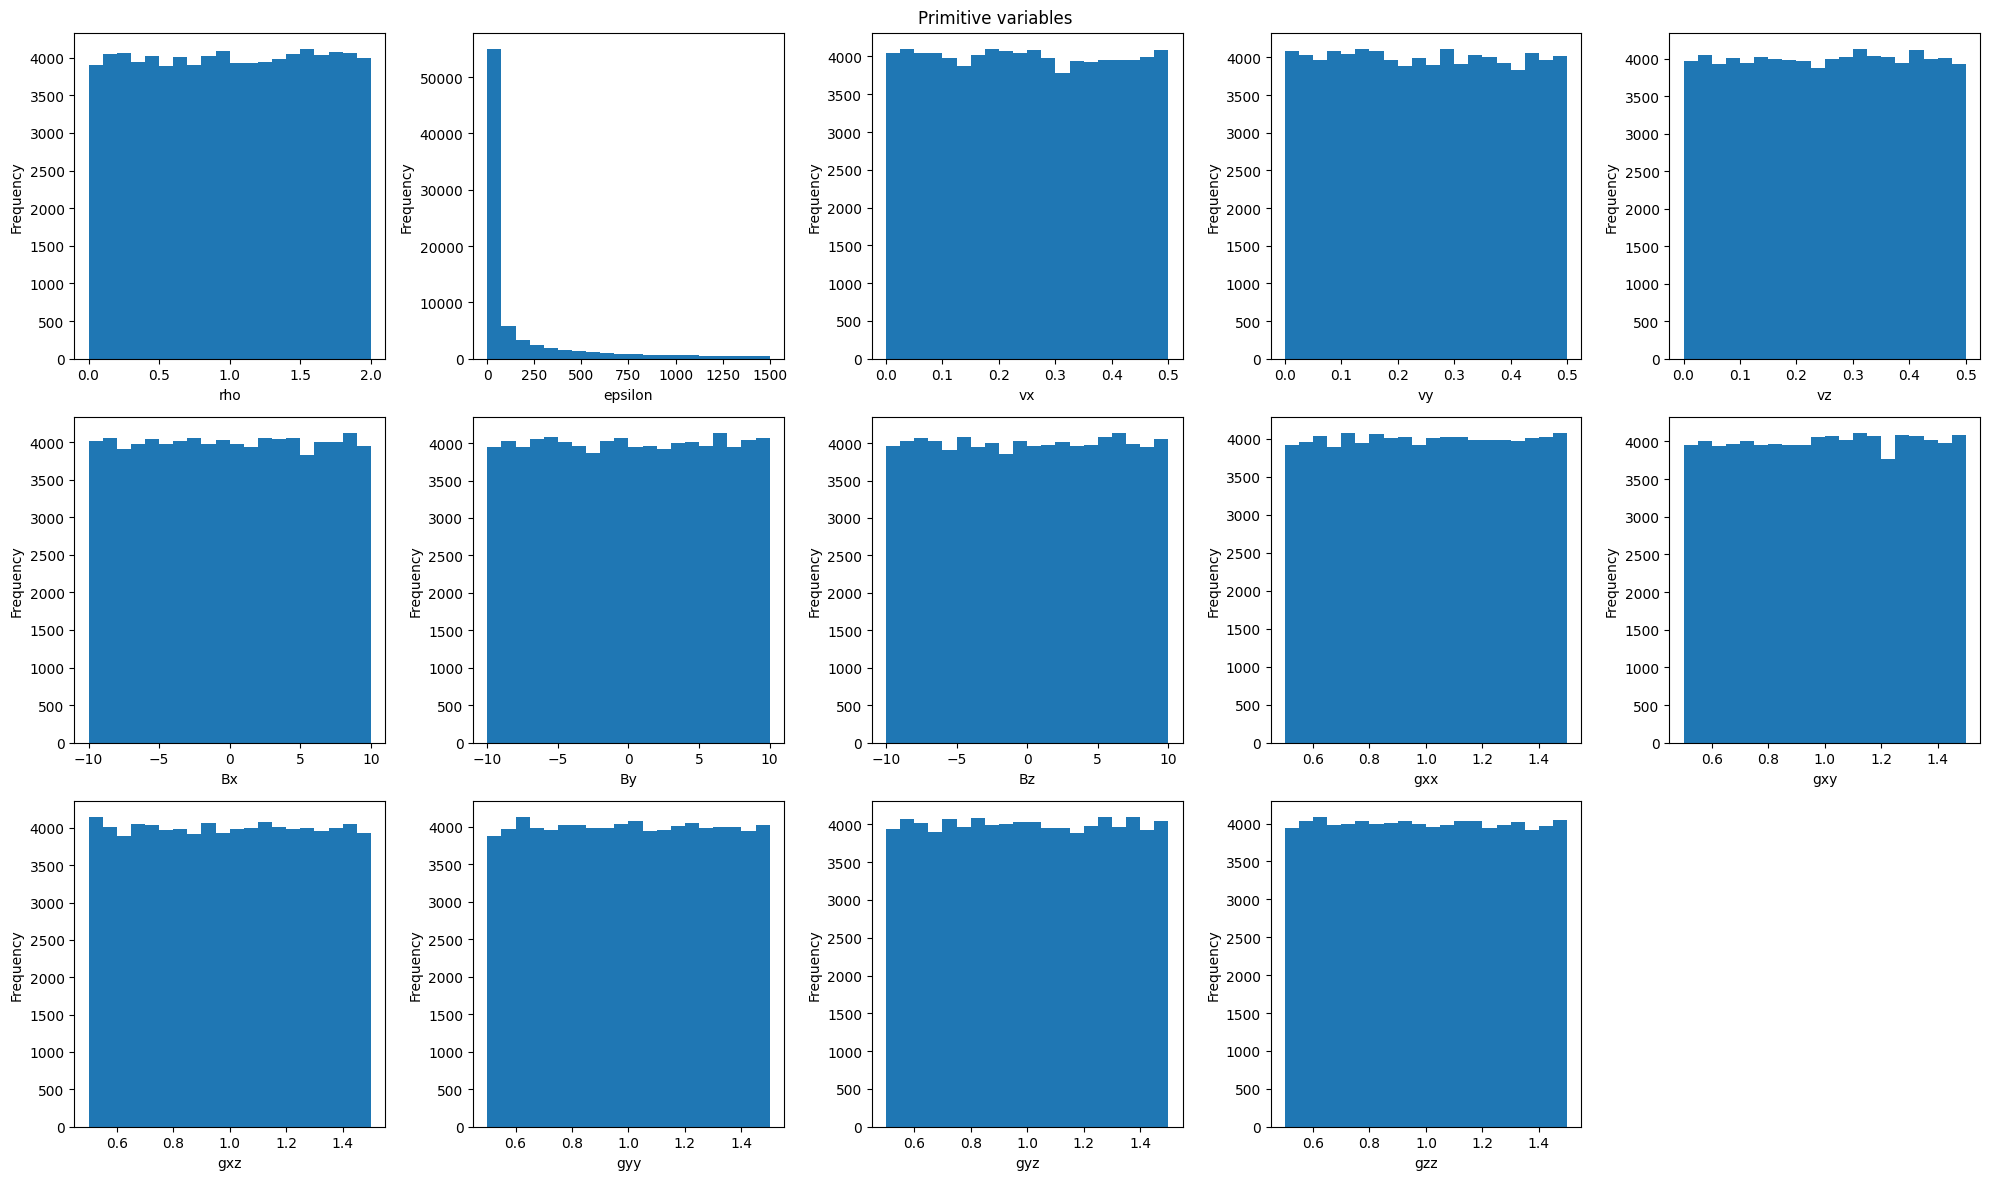

In [ ]:
if not LOAD_DATA_FROM_CSV:
    def plot_histogram(data, xlabel, ylabel, position, bins=20, log_scale=False):
        plt.subplot(3, 5, position)
        plt.hist(data, bins=bins)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if log_scale:
            plt.yscale("log")

    # Plotting the histograms of all the primitive variables
    plt.figure(figsize=(20, 12))

    for i, (key, value) in enumerate(primitive_variables_train.items(), start=1):
        plot_histogram(value, key, "Frequency", i)

    plt.suptitle("Primitive variables")
    plt.tight_layout()
    plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

ValueError: supplied range of [7.51254037822946e-06, inf] is not finite

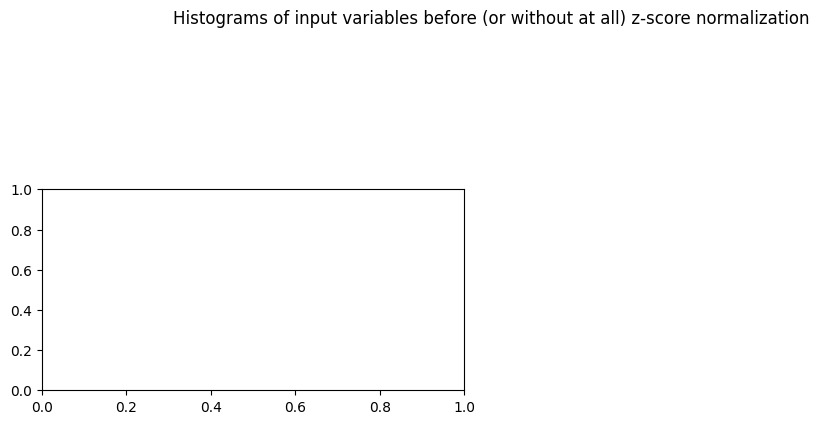

In [ ]:
if not LOAD_DATA_FROM_CSV:
    # List of variable names
    variable_names = ["rho", "epsilon", "vx", "vy", "vz", "Bx", "By", "Bz"]

    # Note how we are only plotting train and not test here. 
    # Plotting histograms of the input variables before z-score normalization
    plt.figure(figsize=(12, 12))
    plt.suptitle('Histograms of input variables before (or without at all) z-score normalization', y=1.03)
    for i in range(8):
        plt.subplot(4, 2, i+1)
        plt.hist(x_train[:, i].cpu(), bins=50) # Must be converted to cpu() for plotting.
        plt.xlabel(variable_names[i])
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

### Data normalization

In [ ]:
# Computing summary statistics of the input variables before and after z-score normalization
print('Summary statistics of input variables before z-score normalization')
print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.nanmean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))

Summary statistics of input variables before z-score normalization
tensor([[    nan,     nan,  2.3443,     nan,     nan],
        [    nan,     nan,  8.4005,     nan,     nan],
        [    nan,     nan,  8.4051,     nan,     nan],
        [    nan,     nan,  8.4014,     nan,     nan],
        [    nan,     nan, 10.5353,     nan,     nan],
        [    nan,     nan,  0.1584,     nan,     nan],
        [    nan,     nan,  0.1580,     nan,     nan],
        [    nan,     nan,  0.1586,     nan,     nan]])


Perform z-score normalization

In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

In [ ]:
if ZSCORE_NORMALIZATION:
    
    # TODO: Add magnetic field variables to the normalization if I decide to use the old code that is commented out here.
    # # Computing the median of each input variable from the training set using torch.nanmedian function
    # D_median = torch.nanmedian(x_train[:, 0])
    # Sx_median = torch.nanmedian(x_train[:, 1])
    # Sy_median = torch.nanmedian(x_train[:, 2])
    # Sz_median = torch.nanmedian(x_train[:, 3])
    # tau_median = torch.nanmedian(x_train[:, 4])

    # # Computing the standard deviation of each input variable from the training set using torch.std function with a boolean mask to ignore nan values
    # D_std = torch.std(x_train[~torch.isnan(x_train[:, 0]), 0])
    # Sx_std = torch.std(x_train[~torch.isnan(x_train[:, 1]), 1])
    # Sy_std = torch.std(x_train[~torch.isnan(x_train[:, 2]), 2])
    # Sz_std = torch.std(x_train[~torch.isnan(x_train[:, 3]), 3])
    # tau_std = torch.std(x_train[~torch.isnan(x_train[:, 4]), 4])


    # # Applying z-score normalization to both train and test sets using the statistics from the training set
    # x_train[:, 0] = torch.sub(x_train[:, 0], D_median).div(D_std)
    # x_train[:, 1] = torch.sub(x_train[:, 1], Sx_median).div(Sx_std)
    # x_train[:, 2] = torch.sub(x_train[:, 2], Sy_median).div(Sy_std)
    # x_train[:, 3] = torch.sub(x_train[:, 3], Sz_median).div(Sz_std)
    # x_train[:, 4] = torch.sub(x_train[:, 4], tau_median).div(tau_std)

    # x_test[:, 0] = torch.sub(x_test[:, 0], D_median).div(D_std)
    # x_test[:, 1] = torch.sub(x_test[:, 1], Sx_median).div(Sx_std)
    # x_test[:, 2] = torch.sub(x_test[:, 2], Sy_median).div(Sy_std)
    # x_test[:, 3] = torch.sub(x_test[:, 3], Sz_median).div(Sz_std)
    # x_test[:, 4] = torch.sub(x_test[:, 4], tau_median).div(tau_std)

    # Computing the mean and standard deviation of each column
    mean = x_train.mean(dim=0)
    std = x_train.std(dim=0)

    # Applying z-score normalization
    x_train = (x_train - mean) / std
    # Use the same mean and std from the training data as we don't want test data leakage.
    x_test = (x_test - mean) / std



Plotting the histograms of the input data after normalization if z-score normalization was performed.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

In [ ]:
if not LOAD_DATA_FROM_CSV:
    if ZSCORE_NORMALIZATION: 
        # List of variable names
        variable_names = ["rho", "epsilon", "vx", "vy", "vz", "Bx", "By", "Bz"]

        # Note how we are only plotting train and not test here. 
        # Plotting histograms of the input variables after z-score normalization
        plt.figure(figsize=(12, 12))
        plt.suptitle('Histograms of input variables after z-score normalization', y=1.03)
        for i in range(8):
            plt.subplot(4, 2, i+1)
            plt.hist(x_train[:, i].cpu(), bins=50) # Must be converted to cpu() for plotting.
            plt.xlabel(variable_names[i])
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()

In [ ]:
if ZSCORE_NORMALIZATION:
    # Computing summary statistics of the input variables after z-score normalization
    print('Summary statistics of input variables after z-score normalization')
    print(torch.stack([torch.min(x_train, dim=0).values, torch.max(x_train, dim=0).values, torch.mean(x_train, dim=0), torch.median(x_train, dim=0).values, torch.std(x_train, dim=0)], dim=1))


### Visualizing input data and labels

In [ ]:
x_train
y_train
x_test
y_test

tensor([0.6319, 4.2208, 2.4116,  ..., 1.6603, 5.4556, 0.2978])

Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 

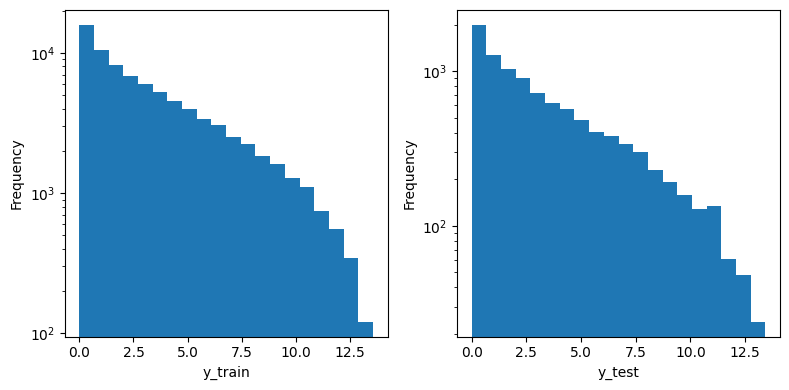

In [ ]:
# Note how we are only plotting train.
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(8, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 8).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Adding an assertion to check that the input tensor has the expected shape and type
        assert isinstance(x, torch.Tensor), "x must be a torch.Tensor"
        assert x.shape[1] == 8, "x must have shape (batch_size, 8)"

        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x


## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if OPTIMIZE:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 2, 6)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 2048) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            #"hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
            #"hidden_activation", ["ReLU", "LeakyReLU"]
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            #"output_activation", ["ReLU", "Softplus", "Linear"]
            "output_activation", ["ReLU", "Linear"]
        ) 
        loss_name = trial.suggest_categorical(
            #"loss", ["MSE", "MAE", "Huber", "LogCosh"] 
            "loss", ["MSE", "MAE", "Huber"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 

        batch_size_list = [32, 48, 64, 96, 128, 256, 512, 1048]
        batch_size = trial.suggest_categorical("batch_size", batch_size_list)
        #batch_size = trial.suggest_int("batch_size", 64, 1048)
        n_epochs = trial.suggest_int("n_epochs", 100, 300) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            # ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
            ["CosineAnnealingLR", "ReduceLROnPlateau", "StepLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    if OPTIMIZE:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            # Added sampling the weight decay and momentum for SGD
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            # Added sampling the weight decay and beta parameters for Adam
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.9, 0.999)
            beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.1, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            if n_epochs < 150:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.3)
            elif n_epochs > 250:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.05, 0.1)
            else:
                t_max_fraction = trial.suggest_uniform('t_max_fraction', 0.1, 0.2)

            T_max = int(n_epochs * t_max_fraction)
            eta_min = trial.suggest_loguniform("eta_min", 1e-7, 1e-2)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added sampling the factor, patience and threshold for ReduceLROnPlateau
            factor = trial.suggest_uniform("factor", 0.1, 0.5)
            patience = trial.suggest_int("patience", 5, 10)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        # # Added using OneCycleLR scheduler as an option
        # elif scheduler_name == "OneCycleLR":
        #         # Added sampling the max_lr and pct_start for OneCycleLR
        #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
        #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer,
        #             max_lr=max_lr,
        #             epochs=n_epochs,
        #             steps_per_epoch=len(train_loader),
        #             pct_start=pct_start,
        #         )
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer)
        elif scheduler_name == "ReduceLROnPlateau":
            # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
            #)
            # Use Dieseldorst et al. settings and add to that a minimum lr.
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.18979341786654758, patience=11, threshold=0.0017197466122611932 #, min_lr=1e-6
                    )
        else:
            scheduler = None

    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

loss_fn: SmoothL1Loss()
batch_size: 49
n_epochs: 3
scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f392cc0bb50>
loss_name: Huber
optimizer_name: RMSprop
scheduler_name: ReduceLROnPlateau
n_units: [555, 458, 115]
n_layers: 3
hidden_activation: ReLU()
output_activation: ReLU()


In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

Epoch 1: Train Loss: nan, Test Loss: nan, Train L1 Norm: nan, Test L1 Norm: nan, Train Linf Norm: nan, Test Linf Norm: nan


Epoch 2: Train Loss: nan, Test Loss: nan, Train L1 Norm: nan, Test L1 Norm: nan, Train Linf Norm: nan, Test Linf Norm: nan


Epoch 3: Train Loss: nan, Test Loss: nan, Train L1 Norm: nan, Test L1 Norm: nan, Train Linf Norm: nan, Test Linf Norm: nan


## Saving

In [ ]:
import json

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'L1 Norm')

(0.001, 100.0)

<Axes: >

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Linf Norm')

(0.001, 100.0)

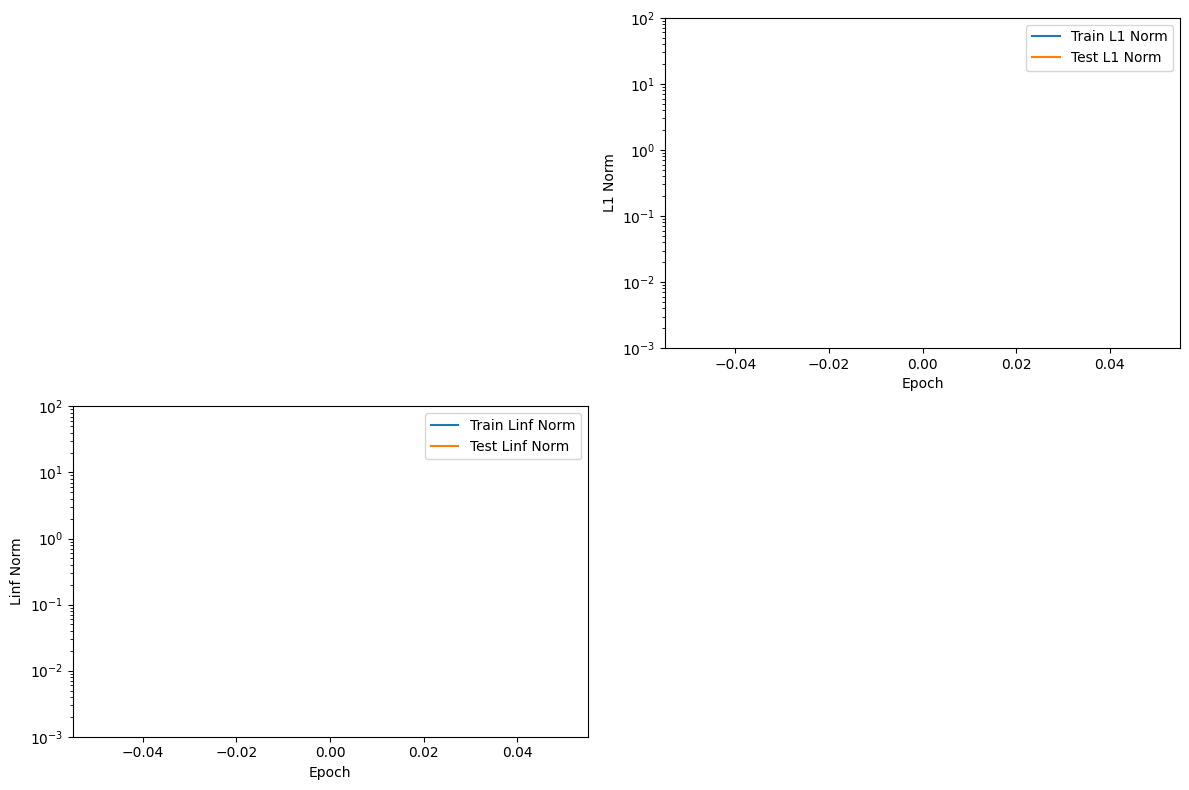

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Huber Loss')

(1e-07, 1.0)

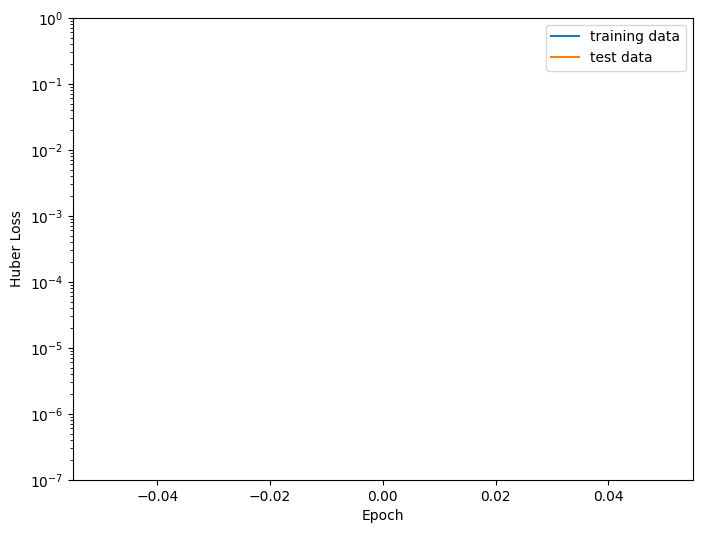

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel(f"{loss_name} Loss")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
if torch.cuda.is_available():
 net_loaded.load_state_dict(torch.load("net.pth"))
else: 
  net_loaded.load_state_dict(torch.load("net.pth", map_location=torch.device('cpu')))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
if torch.cuda.is_available():
  optimizer_loaded_state_dict = torch.load("optimizer.pth")
else:
  optimizer_loaded_state_dict = torch.load("optimizer.pth", map_location=torch.device('cpu'))

if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
if torch.cuda.is_available():
  scheduler_loaded_state_dict = torch.load("scheduler.pth")
else: 
  scheduler_loaded_state_dict = torch.load("scheduler.pth", map_location=torch.device('cpu'))

if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

<All keys matched successfully>

In [ ]:
%%script echo skipping

batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
train_losses_loaded
test_losses_loaded
train_metrics_loaded
test_metrics_loaded

skipping


In [ ]:
train_losses_loaded[-1]
test_losses_loaded[-1]
test_metrics_loaded[-1]['l1_norm']
test_metrics_loaded[-1]['linf_norm']
print(f'Error is {test_metrics_loaded[-1]["l1_norm"] / (3.84e-4)} times bigger than in Dieselhorst et al.')
print(f'Error is {test_metrics_loaded[-1]["linf_norm"] / (8.14e-3)} times bigger than in Dieselhorst et al.')

nan

nan

nan

nan

Error is nan times bigger than in Dieselhorst et al.
Error is nan times bigger than in Dieselhorst et al.


### Visualize loaded results

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

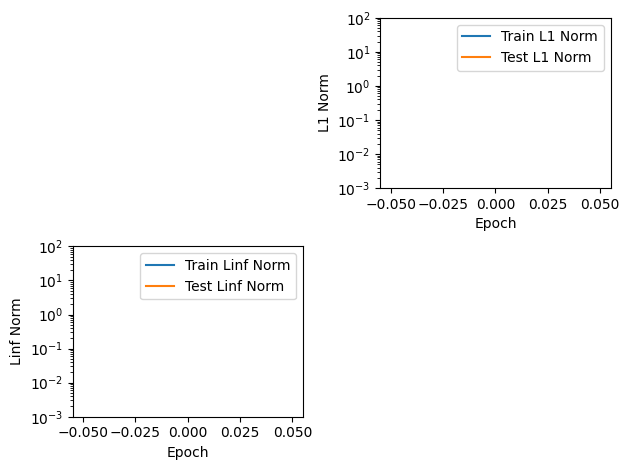

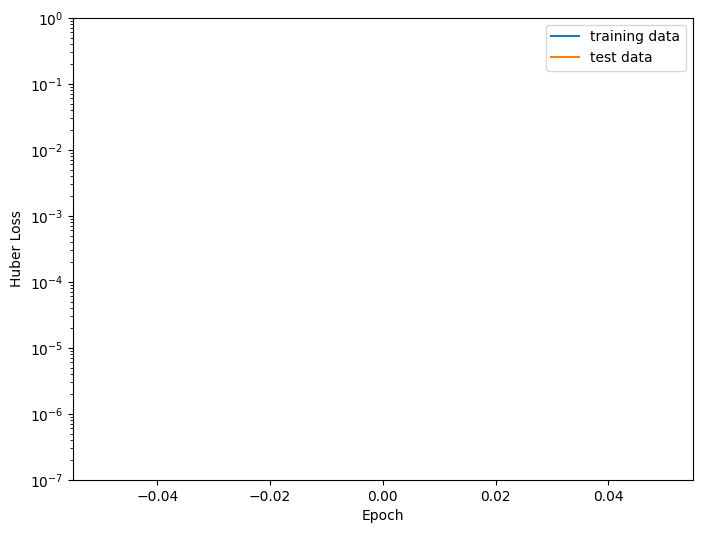

In [ ]:
# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel(f"{loss_name_loaded} Loss")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Counting the number of parameters in the network.

In [ ]:
net_loaded.eval()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(net_loaded)} parameters.')

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=555, bias=True)
    (1): Linear(in_features=555, out_features=458, bias=True)
    (2): Linear(in_features=458, out_features=115, bias=True)
    (3): Linear(in_features=115, out_features=1, bias=True)
  )
)

The model has 312544 parameters.


## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network. Note that `net` is only available if we have trained the model in this session.

In [ ]:
#%%script echo skipping

# Set the network to evaluation mode
net.eval()

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=555, bias=True)
    (1): Linear(in_features=555, out_features=458, bias=True)
    (2): Linear(in_features=458, out_features=115, bias=True)
    (3): Linear(in_features=115, out_features=1, bias=True)
  )
)

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=555, bias=True)
    (1): Linear(in_features=555, out_features=458, bias=True)
    (2): Linear(in_features=458, out_features=115, bias=True)
    (3): Linear(in_features=115, out_features=1, bias=True)
  )
)

In [ ]:
for p1, p2 in zip(net.parameters(), net_loaded.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
        print("Parameters are NOT the same.")
        break
else:
    print("Parameters are the same.")

print("Net device:", next(net.parameters()).device)
print("Net_loaded device:", next(net_loaded.parameters()).device)

Parameters are NOT the same.
Net device: cpu
Net_loaded device: cpu


In [ ]:
#%%script echo skipping

print(list(net.parameters()))

[Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], requires_grad=True), Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
    

In [ ]:
print(list(net_loaded.parameters()))

[Parameter containing:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], requires_grad=True), Parameter containing:
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
    

In [ ]:
n_samples = 20
primitive_variables_example = sample_primitive_variables(n_samples)

# Create arbitrary input
inputs = generate_input_data(primitive_variables_example, device)
print(inputs)

tensor([[2.1096e+00, 7.9179e+00, 4.2761e+00, 3.8931e+00, 5.5833e+00, 2.6130e-01,
         9.3534e-03, 1.1296e-01],
        [2.0391e-01, 4.2456e-01, 1.0333e-01, 7.2036e-01, 9.1905e-01, 8.9877e-02,
         1.1110e-01, 1.1193e-01],
        [       nan,        nan,        nan,        nan,        nan,        nan,
                nan,        nan],
        [4.0693e-01, 2.2794e-01, 3.0099e-01, 3.0263e-01, 7.6846e-01, 9.0452e-02,
         8.8796e-02, 2.3449e-02],
        [       nan,        nan,        nan,        nan,        nan,        nan,
                nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,        nan,
                nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,        nan,
                nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,        nan,
                nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,        nan,

In [ ]:
#%%script echo skipping

# Pass the inputs to the network and get the outputs
outputs = [net(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

[tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>)]

In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input.unsqueeze(0)) for input in inputs]
# Print the outputs
outputs

[tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>),
 tensor([[nan]], grad_fn=<ReluBackward0>)]

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of appropriate shape to trace the model
dummy_input = torch.randn(1, 8).to(device)

# Ensure that net_loaded is in evaluation mode.
net_loaded.eval()

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")

primitive_variables_to_validate = sample_primitive_variables(1)
example_input_to_validate_correct_export_and_import = generate_input_data(primitive_variables_to_validate, device)
print("input shape: ", example_input_to_validate_correct_export_and_import.shape)
print("input: ", example_input_to_validate_correct_export_and_import)
print("Output:", net_loaded(example_input_to_validate_correct_export_and_import))

Net(
  (hidden_activation): ReLU()
  (output_activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=555, bias=True)
    (1): Linear(in_features=555, out_features=458, bias=True)
    (2): Linear(in_features=458, out_features=115, bias=True)
    (3): Linear(in_features=115, out_features=1, bias=True)
  )
)

input shape:  torch.Size([1, 8])
input:  tensor([[nan, nan, nan, nan, nan, nan, nan, nan]])
Output: tensor([[nan]], grad_fn=<ReluBackward0>)


/tmp/ipykernel_889682/2739891698.py:53: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[1] == 8, "x must have shape (batch_size, 8)"
